## TP2 : Classification using Linear & Quadratic Discriminant Analysis


In [1]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la
import os
import seaborn as sea
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
#os.chdir("/home/kronert/Documents/Python/TP2_archive/TP2_archive")
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 13)

Populating the interactive namespace from numpy and matplotlib


/home/cindy/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['info', 'power', 'linalg', 'random', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


This notebook is organized as follows : <br>
1. Reading the data and visualization
2. LDA <br>
    (Implementation numpy + scikit learn, Test with normalized data, Test with augmented features)<br>
3. QDA <br>
    (Implementation numpy + scikit learn) <br>
4. kNN <br>
    (Implementation numpy) <br>

## 1. Reading data
We have 100 training data samples and 200 test samples.

* the 1st column contains the label of the class the sample, 
* columns 2 & 3 contain the coordinates of each sample in 2D.

In [2]:
train = np.loadtxt('synth_train.txt')
test = np.loadtxt('synth_test.txt')

class_train = train[:,0] # labels of training set
class_test = test[:,0] # labels of test set

N_train = train.shape[0]
N_test = test.shape[0]

### Data visualisation

   classe        x1        x2
0     2.0 -0.722211  2.004471
1     2.0 -0.924679  0.483669
2     2.0 -0.766023  0.794329
3     2.0 -0.073289  0.969929
4     1.0 -1.392912  0.999697


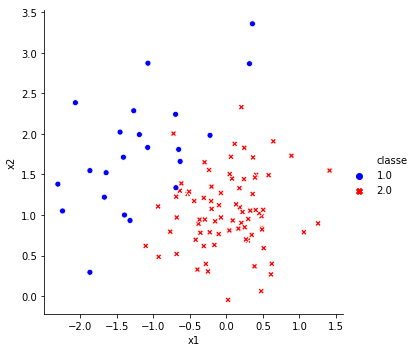

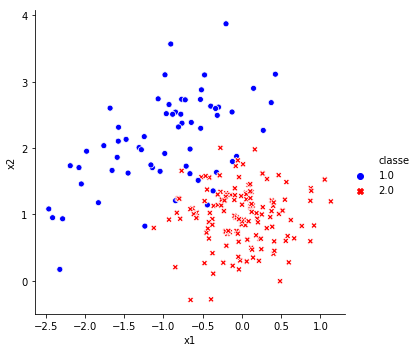

In [3]:
data = pd.DataFrame(train,columns=["classe","x1","x2"])

sea.relplot(x="x1",y="x2",hue="classe",data=data,palette=["b", "r"],style="classe")
print(data.head())

data = pd.DataFrame(test,columns=["classe","x1","x2"])
sea.relplot(x="x1",y="x2",hue="classe",data=data,palette=["b", "r"],style="classe")

The two classes are linearly separable so it does not seem be necessary to add features (x1x2,x1²...) for the LDA. <br>
There does not seem to be any outliers either, so LDA should perform well. <br>
However, in the test set the covariance matrix of both classes clearly do not look the same. Indeed, class to seems to look more like a gaussian with independant variables. (ie the covariance matrix seems almost diagonal), whereas class 1 shows a big positive correlation between feature x1 and feature x2. Therefore, using the same covariance matrix for both might not be such a big idea, and QDA could fit better.

## 2. LDA
### Functions

We use the followings formulas: <br>
empirical frequencies estimate
$$
\pi_k = \frac{N_k}{N}
$$
empirical mean estimate
$$
\mu_k = \frac{1}{N_k}\sum\limits_{n,t_n=k}{x_n}
$$
coraviance matrix estimate
$$
\Sigma = \frac{1}{N}\sum\limits_{k}{N_k\Sigma_k}\\
with\\
\Sigma_k = \frac{1}{N_k}\sum\limits_{n,t_n=k}{(x_n - \mu_k)(x_n - \mu_k)^T} = \frac{1}{N_k}(X_k - \mu_k)^T(X_k - \mu_k)
$$

where $X_k$ is the matrix of dimension ($N_k$,2), with $N_k$ examples of class k 

In [4]:
def LDA_calculer_parametres(data_train):
    """
    Computes optimized parameters for LDA binary classification, given a training set.
    
    parameters :
    - data_train : training set where the first column corresponds to the labels
    
    return :
    - p1, p2 : pi for class 1 and 2
    - mu1, mu2 : empirical means for class 1 and 2
    - N1sigma1 : empirical covariance matrices for class 1 and 2
    
    """
    
    # Ensemble de classe 1
    data_train_1 = data_train[data_train[:,0]==1]
    data_train_2 = data_train[data_train[:,0]==2]
    
    N = data_train.shape[0]
    N1 = data_train_1.shape[0]
    N2 = data_train_2.shape[0]
    
    # calcul des pi
    p1 = N1/N
    p2 = N2/N
    
    # calcul des moyennes
    mu1 = data_train_1[:,1:].mean(axis=0)
    mu2 = data_train_2[:,1:].mean(axis=0)
    
    # calcul de la matrice de covariance
    N1sigma1 =  (data_train_1[:,1:] - mu1).T.dot((data_train_1[:,1:] - mu1))
    N2sigma2 =  (data_train_2[:,1:] - mu2).T.dot((data_train_2[:,1:] - mu2))
    
    sigma = (N1sigma1 + N2sigma2)/N
    
    return p1, p2, mu1, mu2, sigma

In [5]:
def LDA_decision(theta, x):
    """
    Predicts the class (1 or 2) of element x, based on parameters theta.
    If x is in the decision boundary, it arbitrarily predicts 2.
    
    parameters : 
    - theta : vector of parameters for the LDA [p1, p2, mu1, mu2, sigma]
    - x : element we want to classify
    
    return: 
    - i = 1 or 2 the predicted class. i = argmax_i p(t=i,x|theta)
    """
    
    p1, p2, mu1, mu2, sigma = theta
    
    logp1 = np.log(p1) - 0.5*(x - mu1).T.dot(la.inv(sigma)).dot((x - mu1))
    logp2 = np.log(p2) - 0.5*(x - mu2).T.dot(la.inv(sigma)).dot((x - mu2))
    
    if logp1 > logp2:
        return 1
    return 2



def LDA_decision_liste(theta, X):
    """
    Predicts the class of the elements contained in X.
    
    parameters : 
    - theta : vector of parameters for the LDA [p1, p2, mu1, mu2, sigma]
    - X : elements we want to classify
    
    return: 
    - L : vector of predicted classes. L[i] = 1 or 2, is the predicted class of ith element
    """
    n = X.shape[0]
    L=[None]*n
    for i in range(n):
        L[i] = LDA_decision(theta, X[i])
    return L
    

In [6]:
#Scikit learn
LDA = LinearDiscriminantAnalysis()
LDA.fit(train[:,1:],train[:,0])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

### Results

In [7]:
# On calcule les paramètres de notre modèle
print("Paramètres du modèle:")
theta = LDA_calculer_parametres(train)
print(f"p1 = {theta[0]}")
print(f"p2 = {theta[1]}")
print(f"mu1 = {theta[2]}")
print(f"mu2 = {theta[3]}")
print(f"sigma = {theta[4]}")

Paramètres du modèle:
p1 = 0.22
p2 = 0.78
mu1 = [-1.18350693  1.78655437]
mu2 = [0.02868973 1.04424548]
sigma = [[0.3030754  0.08284337]
 [0.08284337 0.27017769]]


Taux d'erreur = 3.0%


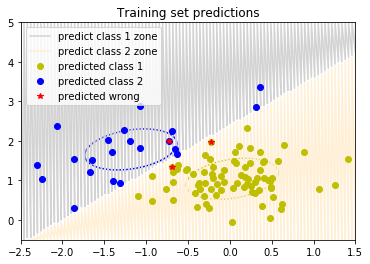

In [8]:
#predictions of training set
c_hat = np.array(LDA_decision_liste(theta, train[:,1:]))


#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-0.5,5,Nx2)  # sampling of the x2 axis
[X1,X2]=np.meshgrid(x1,x2)  
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
class_L = np.array(LDA_decision_liste(theta, x.T))
plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray', label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of training set
plt.plot(train[c_hat==2,1],train[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(train[c_hat==1,1],train[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(train[c_hat!=class_train,1],train[c_hat!=class_train,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("Training set predictions")


# graphical representation of sigma
#quad1(X) = (X-mu1)(Sigma)⁻¹(X-mu2)
quad1 = lambda X : (X - theta[2]).T.dot(la.inv(theta[4])).dot(X - theta[2])
Z1 = [[quad1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
plt.contour( x1,x2,Z1,[1],colors="b")

quad2 = lambda X : (X - theta[3]).T.dot(la.inv(theta[4])).dot(X - theta[3])
Z2 = [[quad2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="y")


print(f"Taux d'erreur = {np.sum(c_hat != class_train)/1}%")

plt.show()

Taux d'erreur = 3.0%


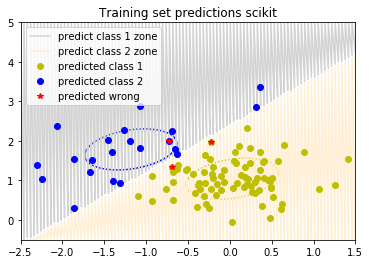

In [9]:
#predictions of train set with scikit learn
c_hat =LDA.predict(train[:,1:])

#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-0.5,5,Nx2)  # sampling of the x2 axis
[X1,X2]=np.meshgrid(x1,x2)  
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
class_L = np.array(LDA_decision_liste(theta, x.T))
plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of training set
plt.plot(train[c_hat==2,1],train[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(train[c_hat==1,1],train[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(train[c_hat!=class_train,1],train[c_hat!=class_train,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("Training set predictions scikit")


# graphical representation of sigma
#quad1(X) = (X-mu1)(Sigma)⁻¹(X-mu2)
quad1 = lambda X : (X - theta[2]).T.dot(la.inv(theta[4])).dot(X - theta[2])
Z1 = [[quad1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
plt.contour( x1,x2,Z1,[1],colors="b")

quad2 = lambda X : (X - theta[3]).T.dot(la.inv(theta[4])).dot(X - theta[3])
Z2 = [[quad2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="y")


print(f"Taux d'erreur = {np.sum(c_hat != class_train)/1}%")

plt.show()

Taux d'erreur = 5.5%


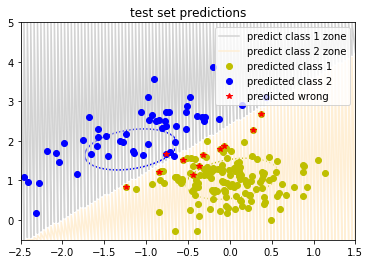

In [10]:
#predictions of test set
c_hat = np.array(LDA_decision_liste(theta, test[:,1:]))


#plot predictions zones (ie decision boundaries)
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of test set
plt.plot(test[c_hat==2,1],test[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(test[c_hat==1,1],test[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(test[c_hat!=class_test,1],test[c_hat!=class_test,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("test set predictions")


# graphical representation of sigma
#quad1(X) = (X-mu1)(Sigma)⁻¹(X-mu2)
quad1 = lambda X : (X - theta[2]).T.dot(la.inv(theta[4])).dot(X - theta[2])
Z1 = [[quad1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
plt.contour( x1,x2,Z1,[1],colors="b")

quad2 = lambda X : (X - theta[3]).T.dot(la.inv(theta[4])).dot(X - theta[3])
Z2 = [[quad2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="y")


print(f"Taux d'erreur = {np.sum(c_hat != class_test)/2}%")

plt.show()

Taux d'erreur = 5.5%


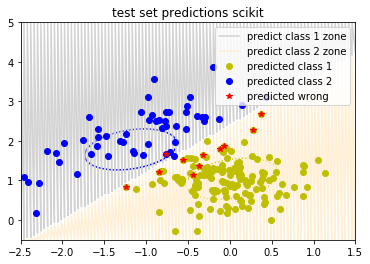

In [11]:
#predictions of test set with scikit learn
c_hat =LDA.predict(test[:,1:])


#plot predictions zones (ie decision boundaries)
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of test set
plt.plot(test[c_hat==2,1],test[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(test[c_hat==1,1],test[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(test[c_hat!=class_test,1],test[c_hat!=class_test,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("test set predictions scikit")


# graphical representation of sigma
#quad1(X) = (X-mu1)(Sigma)⁻¹(X-mu2)
quad1 = lambda X : (X - theta[2]).T.dot(la.inv(theta[4])).dot(X - theta[2])
Z1 = [[quad1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
plt.contour( x1,x2,Z1,[1],colors="b")

quad2 = lambda X : (X - theta[3]).T.dot(la.inv(theta[4])).dot(X - theta[3])
Z2 = [[quad2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="y")


print(f"Taux d'erreur = {np.sum(c_hat != class_test)/2}%")

plt.show()

### Sensitivity of LDA to normalization

In [12]:
## Normalization of train and test set
train_norm = train.copy()
train_norm [:,1:] = (train [:,1:] - np.mean(train [:,1:],axis=0)) / np.std(train [:,1:],axis=0)
test_norm = test.copy()
test_norm [:,1:] = (test [:,1:] - np.mean(train [:,1:],axis=0)) / np.std(train [:,1:],axis=0)

## New parameters with normalized data
theta_norm = LDA_calculer_parametres(train_norm)

Taux d'erreur = 3.0%


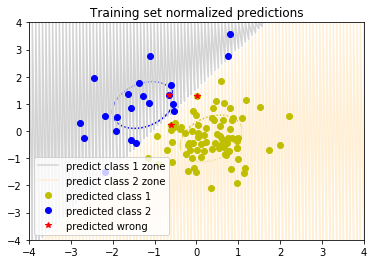

In [13]:
# predictions of train normalized data
c_hat = np.array(LDA_decision_liste(theta_norm, train_norm[:,1:]))


#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-4,4,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-4,4,Nx2)  # sampling of the x2 axis
[X1,X2]=np.meshgrid(x1,x2)  
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
class_L = np.array(LDA_decision_liste(theta_norm, x.T))

plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray', label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of training set
plt.plot(train_norm[c_hat==2,1],train_norm[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(train_norm[c_hat==1,1],train_norm[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(train_norm[c_hat!=class_train,1],train_norm[c_hat!=class_train,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("Training set normalized predictions")


# graphical representation of sigma
#quad1(X) = (X-mu1)(Sigma)⁻¹(X-mu2)
quad1 = lambda X : (X - theta_norm[2]).T.dot(la.inv(theta_norm[4])).dot(X - theta_norm[2])
Z1 = [[quad1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
plt.contour( x1,x2,Z1,[1],colors="b")

quad2 = lambda X : (X - theta_norm[3]).T.dot(la.inv(theta_norm[4])).dot(X - theta_norm[3])
Z2 = [[quad2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="y")


print(f"Taux d'erreur = {np.sum(c_hat != class_train)/1}%")

plt.show()

Taux d'erreur = 5.5%


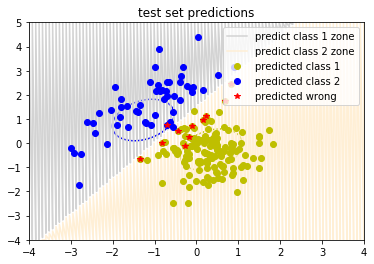

In [14]:
# predictions of test normalized data
c_hat = np.array(LDA_decision_liste(theta_norm, test_norm[:,1:]))

#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-4,4,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-4,5,Nx2)  # sampling of the x2 axis
[X1,X2]=np.meshgrid(x1,x2)  
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
class_L = np.array(LDA_decision_liste(theta_norm, x.T))

plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of test set
plt.plot(test_norm[c_hat==2,1],test_norm[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(test_norm[c_hat==1,1],test_norm[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(test_norm[c_hat!=class_test,1],test_norm[c_hat!=class_test,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("test set predictions")


# graphical representation of sigma
#quad1(X) = (X-mu1)(Sigma)⁻¹(X-mu2)
quad1 = lambda X : (X - theta_norm[2]).T.dot(la.inv(theta_norm[4])).dot(X - theta_norm[2])
Z1 = [[quad1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
plt.contour( x1,x2,Z1,[1],colors="b")

quad2 = lambda X : (X - theta_norm[3]).T.dot(la.inv(theta_norm[4])).dot(X - theta_norm[3])
Z2 = [[quad2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="y")


print(f"Taux d'erreur = {np.sum(c_hat != class_test)/2}%")

plt.show()

Le LDA semble insensible à la renormalisation, au moins sur ce dataset.
En fait le LDA est insensible à la normalisation car la comparaison de p(xn,tn|theta) pour les 2 classes restera la même.

### Adding new features

In [15]:
## New training set
x1_square = np.square(train[:,1]).reshape((N_train,1))
x2_square = np.square(train[:,2]).reshape((N_train,1))
x1x2 = (train[:,1]*train[:,2]).reshape((N_train,1))
train_augmented = np.concatenate((train,x1_square,x2_square,x1x2),axis=1 )
print(train_augmented[:5])


## New test set
x1_square = np.square(test[:,1]).reshape((N_test,1))
x2_square = np.square(test[:,2]).reshape((N_test,1))
x1x2 = (test[:,1]*test[:,2]).reshape((N_test,1))
test_augmented = np.concatenate((test,x1_square,x2_square,x1x2),axis=1 )
print(test_augmented[:5])


## New parameters with augmented data
theta_augmented = LDA_calculer_parametres(train_augmented)
print(f"p1 = {theta_augmented[0]}")
print(f"p2 = {theta_augmented[1]}")
print(f"mu1 = {theta_augmented[2]}")
print(f"mu2 = {theta_augmented[3]}")
print(f"sigma = {theta_augmented[4]}")

[[ 2.         -0.72221141  2.00447087  0.52158933  4.01790347 -1.44765174]
 [ 2.         -0.92467912  0.48366928  0.85503147  0.23393598 -0.44723889]
 [ 2.         -0.76602281  0.79432891  0.58679095  0.63095841 -0.60847407]
 [ 2.         -0.07328948  0.96992915  0.00537135  0.94076255 -0.0710856 ]
 [ 1.         -1.39291198  0.99969709  1.94020378  0.99939427 -1.39249005]]
[[ 2.          0.54837733  1.2213453   0.3007177   1.49168435  0.66975808]
 [ 2.         -0.51618236  1.56239592  0.26644422  2.44108102 -0.80648121]
 [ 2.         -0.92877833  0.92107217  0.86262919  0.84837393 -0.85547187]
 [ 2.          0.07000405  0.61976747  0.00490057  0.38411171  0.04338623]
 [ 2.          0.26702843  1.10944064  0.07130418  1.23085853  0.2962522 ]]
p1 = 0.22
p2 = 0.78
mu1 = [-1.18350693  1.78655437  1.91733508  3.67943615 -1.80647861]
mu2 = [0.02868973 1.04424548 0.24366052 1.29928524 0.0493191 ]
sigma = [[ 0.3030754   0.08284337 -0.20138032  0.31339088  0.36489617]
 [ 0.08284337  0.27017769 

Taux d'erreur = 5.0%


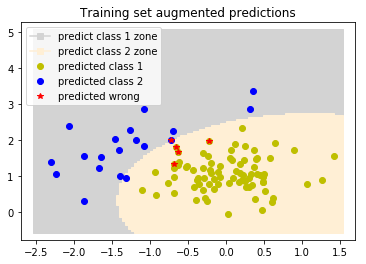

In [16]:
# predictions of train augmented data
c_hat = np.array(LDA_decision_liste(theta_augmented, train_augmented[:,1:]))

#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-0.5,5,Nx2) 
[X1,X2]=np.meshgrid(x1,x2)  
X1flatten_square = np.square(X1.flatten('F'))
X2flatten_square = np.square(X2.flatten('F'))
X1X2flatten = (X1.flatten('F'))*(X2.flatten('F'))
x=np.vstack((X1.flatten('F'),X2.flatten('F'),X1flatten_square,X2flatten_square,X1X2flatten))
class_L = np.array(LDA_decision_liste(theta_augmented, x.T))

plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray', marker = "s",label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',marker="s",label = "predict class 2 zone")



#plot predictions of training set
plt.plot(train_augmented[c_hat==2,1],train_augmented[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(train_augmented[c_hat==1,1],train_augmented[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(train_augmented[c_hat!=class_train,1],train_augmented[c_hat!=class_train,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("Training set augmented predictions")

print(f"Taux d'erreur = {np.sum(c_hat != class_train)/1}%")


Taux d'erreur = 5.5%


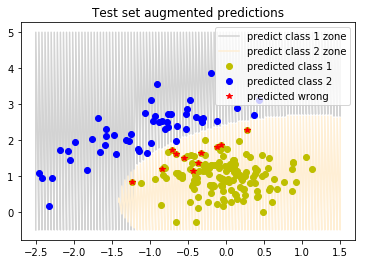

In [17]:
# predictions of train augmented data
c_hat = np.array(LDA_decision_liste(theta_augmented, test_augmented[:,1:]))

#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-0.5,5,Nx2) 
[X1,X2]=np.meshgrid(x1,x2)  
X1flatten_square = np.square(X1.flatten('F'))
X2flatten_square = np.square(X2.flatten('F'))
X1X2flatten = (X1.flatten('F'))*(X2.flatten('F'))
x=np.vstack((X1.flatten('F'),X2.flatten('F'),X1flatten_square,X2flatten_square,X1X2flatten))
class_L = np.array(LDA_decision_liste(theta_augmented, x.T))

plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray', label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")



#plot predictions of training set
plt.plot(test_augmented[c_hat==2,1],test_augmented[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(test_augmented[c_hat==1,1],test_augmented[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(test_augmented[c_hat!=class_test,1],test_augmented[c_hat!=class_test,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("Test set augmented predictions")

print(f"Taux d'erreur = {np.sum(c_hat != class_test)/2}%")


With augmented features, as expected, we can see that it does not change the error rate. The test data and training data seemed linearly separable so adding features seems useless.
As we have no clue about our data, we also could have tried with exponential features, it gives a different shape of the decision boundaries.

In [18]:
## New training set
x1_exp = np.exp(train[:,1]).reshape((N_train,1))
x2_exp = np.exp(train[:,2]).reshape((N_train,1))
x1x2 = (train[:,1]*train[:,2]).reshape((N_train,1))
train_augmented = np.concatenate((train,x1_exp,x2_exp,x1x2),axis=1 )


## New parameters with augmented data
theta_augmented = LDA_calculer_parametres(train_augmented)
print(f"p1 = {theta_augmented[0]}")
print(f"p2 = {theta_augmented[1]}")
print(f"mu1 = {theta_augmented[2]}")
print(f"mu2 = {theta_augmented[3]}")
print(f"sigma = {theta_augmented[4]}")

p1 = 0.22
p2 = 0.78
mu1 = [-1.18350693  1.78655437  0.40677439  7.69637793 -1.80647861]
mu2 = [0.02868973 1.04424548 1.16571121 3.16406284 0.0493191 ]
sigma = [[ 0.3030754   0.08284337  0.28215207  0.69269133  0.36489617]
 [ 0.08284337  0.27017769  0.05471565  1.40995726  0.0542968 ]
 [ 0.28215207  0.05471565  0.34968175  0.44398081  0.33595069]
 [ 0.69269133  1.40995726  0.44398081 10.5261316   0.73877762]
 [ 0.36489617  0.0542968   0.33595069  0.73877762  0.65143414]]


Taux d'erreur = 5.0%


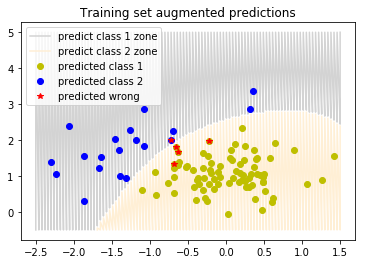

In [19]:
# predictions of train augmented data
c_hat = np.array(LDA_decision_liste(theta_augmented, train_augmented[:,1:]))

#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-0.5,5,Nx2) 
[X1,X2]=np.meshgrid(x1,x2)  
X1flatten_exp = np.exp(X1.flatten('F'))
X2flatten_exp = np.exp(X2.flatten('F'))
X1X2flatten = (X1.flatten('F'))*(X2.flatten('F'))
x=np.vstack((X1.flatten('F'),X2.flatten('F'),X1flatten_exp,X2flatten_exp,X1X2flatten))
class_L = np.array(LDA_decision_liste(theta_augmented, x.T))

plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")



#plot predictions of training set
plt.plot(train_augmented[c_hat==2,1],train_augmented[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(train_augmented[c_hat==1,1],train_augmented[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(train_augmented[c_hat!=class_train,1],train_augmented[c_hat!=class_train,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("Training set augmented predictions")

print(f"Taux d'erreur = {np.sum(c_hat != class_train)/1}%")


## QDA
### Functions

In [20]:

def QDA_calculer_paramètres(data_train):
    # Ensemble de classe 1
    data_train_1 = data_train[data_train[:,0]==1]
    data_train_2 = data_train[data_train[:,0]==2]
    
    N = data_train.shape[0]
    N1 = data_train_1.shape[0]
    N2 = data_train_2.shape[0]
    
    # calcul des pi
    p1 = N1/Nx1
    p2 = N2/Nx1
    
    # calcul des moyennes
    mu1 = data_train_1[:,1:].mean(axis=0)
    mu2 = data_train_2[:,1:].mean(axis=0)
    
    # calcul de la matrice de covariance
    sigma1 =  (data_train_1[:,1:] - mu1).T.dot((data_train_1[:,1:] - mu1))/N1
    sigma2 =  (data_train_2[:,1:] - mu2).T.dot((data_train_2[:,1:] - mu2))/N2
    
    
    
    return p1, p2, mu1, mu2, sigma1, sigma2

In [21]:
def QDA_decision(teta, x):
    p1, p2, mu1, mu2, sigma1,sigma2 = teta
    
    logp1 = np.log(p1) -0.5*(x - mu1).T.dot(la.inv(sigma1)).dot((x - mu1))
    logp2 = np.log(p2) -0.5*(x - mu2).T.dot(la.inv(sigma2)).dot((x - mu2))
    
    if logp1 > logp2:
        return 1
    return 2
def QDA_decision_liste(teta, X):
    n = X.shape[0]
    L=[None]*n
    for i in range(n):
        L[i] = QDA_decision(teta, X[i])
    return L


#Scikit learn
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(train[:,1:],train[:,0])

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

### Results 

In [22]:
# On calcul les paramètres de notre modèle
tetaQ = QDA_calculer_paramètres(train)
print(f"p1 = {tetaQ[0]}")
print(f"p2 = {tetaQ[1]}")
print(f"mu1 = {tetaQ[2]}")
print(f"mu2 = {tetaQ[3]}")
print(f"sigma1 = {tetaQ[4]}")
print(f"sigma2 = {tetaQ[5]}")

p1 = 0.22
p2 = 0.78
mu1 = [-1.18350693  1.78655437]
mu2 = [0.02868973 1.04424548]
sigma1 = [[0.51664642 0.30792087]
 [0.30792087 0.48765965]]
sigma2 = [[0.24283742 0.01935998]
 [0.01935998 0.20883663]]


Taux d'erreur = 4.0%


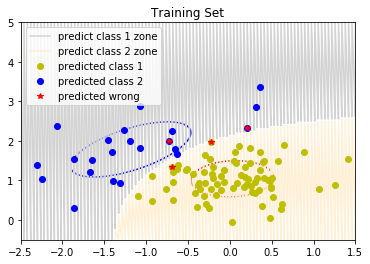

In [23]:
# Prediction training set QDA
c_hat = np.array(QDA_decision_liste(tetaQ, train[:,1:]))

#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-0.5,5,Nx2)  # sampling of the x2 axis
[X1,X2]=np.meshgrid(x1,x2)  
x=np.hstack((X1.flatten('F'),X2.flatten('F')))
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
class_L = np.array(QDA_decision_liste(tetaQ, x.T))
plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray', label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of training set
plt.plot(train[c_hat==2,1],train[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(train[c_hat==1,1],train[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(train[c_hat!=class_train,1],train[c_hat!=class_train,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("Training set predictions")


# graphical representation of sigmas
quadQ1 = lambda X : (X - tetaQ[2]).T.dot(la.inv(tetaQ[4])).dot(X - tetaQ[2])
Z1 = [[quadQ1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z1,[1],colors="b")

quadQ2 = lambda X : (X - tetaQ[3]).T.dot(la.inv(tetaQ[5])).dot(X - tetaQ[3])
Z2 = [[quadQ2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="r")

title("Training Set")

print(f"Taux d'erreur = {np.sum(c_hat != class_train)/1}%")

plt.show()

taux d'erreur = 4.5%


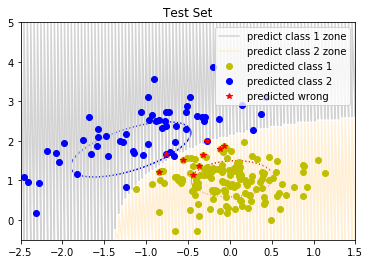

In [24]:
#predictions of test set
c_hat = np.array(QDA_decision_liste(tetaQ, test[:,1:]))


#plot predictions zones (ie decision boundaries)
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of test set
plt.plot(test[c_hat==2,1],test[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(test[c_hat==1,1],test[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(test[c_hat!=class_test,1],test[c_hat!=class_test,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("test set predictions")


# graphical representation of sigmas
quadQ1 = lambda X : (X - tetaQ[2]).T.dot(la.inv(tetaQ[4])).dot(X - tetaQ[2])
Z1 = [[quadQ1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z1,[1],colors="b")

quadQ2 = lambda X : (X - tetaQ[3]).T.dot(la.inv(tetaQ[5])).dot(X - tetaQ[3])
Z2 = [[quadQ2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="r")

title("Test Set")
print(f"taux d'erreur = {np.sum(c_hat != class_test)/2}%")
plt.show()


taux d'erreur = 5.0%


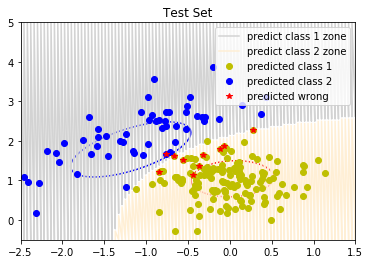

In [25]:
#predictions of test set with scikit learn
c_hat = QDA.predict( test[:,1:])

#plot predictions zones (ie decision boundaries)
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")


#plot predictions of test set
plt.plot(test[c_hat==2,1],test[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(test[c_hat==1,1],test[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(test[c_hat!=class_test,1],test[c_hat!=class_test,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("test set predictions scikit")


# graphical representation of sigmas
quadQ1 = lambda X : (X - tetaQ[2]).T.dot(la.inv(tetaQ[4])).dot(X - tetaQ[2])
Z1 = [[quadQ1(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z1,[1],colors="b")

quadQ2 = lambda X : (X - tetaQ[3]).T.dot(la.inv(tetaQ[5])).dot(X - tetaQ[3])
Z2 = [[quadQ2(np.r_[t1,t2]) for t1 in x1] for t2 in x2]
contour(x1,x2,Z2,[1],colors="r")

title("Test Set")
print(f"taux d'erreur = {np.sum(c_hat != class_test)/2}%")
plt.show()


We don't have the exact same error rate with scikit learn, this is due to the point in the decision boundary (the leftmost point here). Because for the points which are in the decision boundary, we arbitrarily predict them as belonging to class 1.

## Conclusion of the comparison between LDA and QDA

In [26]:
error_rates = np.array([["Training set", "3%", "4%"],
                       ["Test set", "5.5%","4.5%"]])
data = pd.DataFrame(error_rates,
                    columns=["Set","error LDA","error QDA"])
print(data)

            Set error LDA error QDA
0  Training set        3%        4%
1      Test set      5.5%      4.5%


QDA performs better in this case than LDA. <br>
As we said earlier (in section "reading data"), one of the reason for this could be that the covariance matrices do not look the same, and therefore QDA could perform better. <br>
Plus, QDA fits better the training set and in this case, our training set is quite large, we don't suffer from high variance.<br>
Lastly, here, there is only 2 classes so computing 2 covariance matrices is not very expensive, computationnally speaking.

# KNN 

### Functions

In [27]:
def KNN(data_train, x, K = 5):
    """
    kNN algorithm, by default K = 5
    
    parameters:
    - data_train : data with first columns corresponds to labels
    - x : the element which we want to predict the class
    - K : number of neighbours taken into account
    
    returns 
    - predicted class : 1 or 2
    
    """
    n = data_train.shape[0]
    distances = la.norm(data_train[:,1:] - x,axis = 1)
    L = list(np.hstack((data_train,distances.reshape((n,1)))))
    L.sort(key=lambda x : x[-1])
    
    nb1 = (np.array(L[:K])==1).sum()
    
    if nb1 >= K/2:
        return 1
    return 2

def KNN_multiple(data_train, X, K = 5):
    """
    returns : 
    - L : list of predicted classes for the elements in X
    """
    n = X.shape[0]
    L = []
    for i in range(n):
        L.append(KNN(data_train, X[i,:],K))
    return L

In [28]:
## Normalization of data
train_norm = train.copy()
train_norm [:,1:] = (train [:,1:] - np.mean(train [:,1:],axis=0)) / np.std(train [:,1:],axis=0)
test_norm = test.copy()
test_norm [:,1:] = (test [:,1:] - np.mean(train [:,1:],axis=0)) / np.std(train [:,1:],axis=0)

### Results

Best K found train set  1
Best K found validation set  4
Best K found test set  3


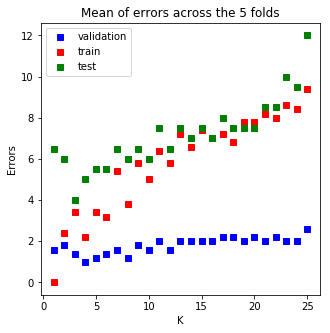

In [29]:
## Cross validation to choose K

##Settings
N_val = 20
N_fold = int(np.ceil(N_train/N_val))
N_K = 25
train_cross = train.copy()
##Shuffle training set
np.random.shuffle(train_cross) 


##Cross-validation
erreur_val = np.zeros((N_fold,N_K))
erreur_train = np.zeros((N_fold,N_K))


for p in range(N_fold):
    # extraction of validation set, extraction of trainset
    val_set = train_cross[p*N_val:(p+1)*N_val]
    train_set = train_cross[hstack((arange(p*N_val),arange((p+1)*N_val,train.shape[0])))]
    class_train_cross = train_set[:,0]
    class_val_cross = val_set[:,0]
    
    # normalization
    mean_train = np.concatenate(([0],np.mean(train_set[:,1:],axis=0)))
    std_train = np.concatenate(([1],np.std(train_set[:,1:],axis=0)))
    
    train_set_norm = (train_set-mean_train)/std_train
    val_set_norm = (val_set-mean_train)/std_train

    for K in range(1,N_K+1):
        # compute errors
        c_hat_train = np.array(KNN_multiple(train_set_norm,train_set_norm[:,1:],K))
        erreur_train[p,K-1] = np.sum(c_hat_train != class_train_cross)/1
        
        c_hat_val = np.array(KNN_multiple(train_set_norm,val_set_norm[:,1:],K))
        erreur_val[p,K-1] = np.sum(c_hat_val != class_val_cross)/1
        
        
erreur_test = np.zeros((N_K))
for K in range(1,N_K+1):
    c_hat_test = np.array(KNN_multiple(train_norm,test_norm[:,1:],K))
    erreur_test[K-1] = np.sum(c_hat_test != class_test)/2

##Plots
plt.figure(figsize=(5,5))
plt.title('Mean of errors across the 5 folds')
plt.xlabel('K')
plt.ylabel('Errors')

plt.plot(np.arange(1,N_K+1),np.mean(erreur_val,axis=0),"bs")
plt.plot(np.arange(1,N_K+1),np.mean(erreur_train,axis=0),"rs")
plt.plot(np.arange(1,N_K+1),erreur_test,"gs")
plt.legend(('validation','train','test'))
best_K_val = np.argmin(np.mean(erreur_val,axis=0))+1
print("Best K found train set ",np.argmin(np.mean(erreur_train,axis=0))+1)
print("Best K found validation set ",best_K_val)
print("Best K found test set ",np.argmin(erreur_test)+1)

In [30]:
K=4

Taux d'erreur = 3.0%


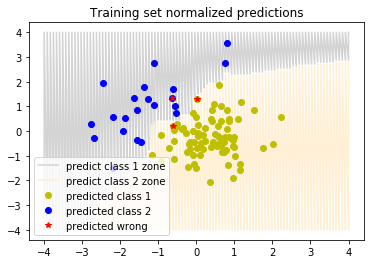

In [31]:
c_hat = np.array(KNN_multiple(train_norm,train_norm[:,1:],K))#predictions
class_train = train[:,0]

#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-4,4,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-4,4,Nx2)  # sampling of the x2 axis
[X1,X2]=np.meshgrid(x1,x2)  
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
class_L = np.array(KNN_multiple(train_norm,x.T,K))

plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")

#plot predictions of training set
plt.plot(train_norm[c_hat==2,1],train_norm[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(train_norm[c_hat==1,1],train_norm[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(train_norm[c_hat!=class_train,1],train_norm[c_hat!=class_train,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("Training set normalized predictions")




print(f"Taux d'erreur = {np.sum(c_hat != class_train)/1}%")

plt.show()

Taux d'erreur = 5.0%


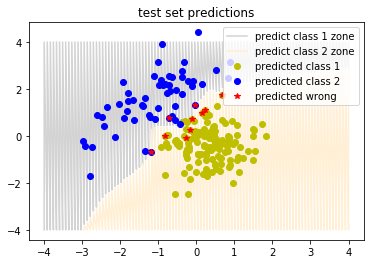

In [32]:
# predictions of test normalized data
c_hat = np.array(KNN_multiple(train_norm,test_norm[:,1:],K))


#plot predictions zones (ie decision boundaries)
Nx1=100 # number of samples for display
Nx2=100
x1=np.linspace(-4,4,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-4,4,Nx2)  # sampling of the x2 axis
[X1,X2]=np.meshgrid(x1,x2)  
x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
class_L = np.array(KNN_multiple(train_norm,x.T,K))
plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray', label = "predict class 1 zone")
plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")



#plot predictions of test set
plt.plot(test_norm[c_hat==2,1],test_norm[c_hat==2,2],'yo',label = "predicted class 1")
plt.plot(test_norm[c_hat==1,1],test_norm[c_hat==1,2],'bo',label = "predicted class 2")
plt.plot(test_norm[c_hat!=class_test,1],test_norm[c_hat!=class_test,2],'r*',label = "predicted wrong")
plt.legend()
plt.title ("test set predictions")

print(f"Taux d'erreur = {np.sum(c_hat != class_test)/2}%")

plt.show()

In this case, kNN performs slightly worse than QDA and slightly better than LDA. <br>
In this problem, the two classes are quite well linearly separated, but there are some data mixed near the decision boundary, that's why LDA performs less well than the other methods. <br>
QDA is kind of in the middle of kNN and LDA: it is not as flexible as kNN. (kNN does not suppose anything about the structure of the data, whereas QDA suppose them a relatively well linearly separated.), and QDA is more flexible than LDA. <br>
Maybe by adding more features on LDA we could perform as well as QDA, but we actually do not have any information about the data so adding features randomly and doing well in this case would not be useful in reality, as we don't have access to the right labels of the test set in real life.